# 🗂️ Step 1: Load and check missing Data

In [72]:
import pandas as pd, numpy as np

df_train = pd.read_pickle("train_processed.pkl")
df_test = pd.read_pickle("test_processed.pkl")

df_train.isnull().sum()

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
house_age        0
renovated        0
dtype: int64

#### **Clealy there are no missing values.**

# 🔢 Step 2: Train test split

In [73]:
np.random.seed(42)
from sklearn.model_selection import train_test_split

X = df_train
y = df_train['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train contains {len(X_train)} instances for training")
print(f"X_val contains {len(X_val)} instances for validation")
print(f"y_train contains {len(y_train)} instances of training prices (target)")
print(f"y_val contains {len(X_val)} instances of validation prices (target)")

X_train contains 12967 instances for training
X_val contains 3242 instances for validation
y_train contains 12967 instances of training prices (target)
y_val contains 3242 instances of validation prices (target)


# 🤖 Step 3: Training XGBoost Model with early stopping

In [74]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

XGB_model = XGBRegressor(
    n_estimators=2000,          # large, rely on early stopping
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    tree_method="hist",
    eval_metric="rmse",
    early_stopping_rounds=200,
    random_state=42
)

XGB_model.fit(
    X_train.drop(['price', 'id'], axis=1), y_train,
    eval_set=[(X_val.drop(['price', 'id'], axis=1), y_val)],
    verbose=100
)

[0]	validation_0-rmse:342553.48735
[100]	validation_0-rmse:120713.72518
[200]	validation_0-rmse:115826.41746
[300]	validation_0-rmse:113846.52982
[400]	validation_0-rmse:113174.79807
[500]	validation_0-rmse:112726.48383
[600]	validation_0-rmse:112495.24585
[700]	validation_0-rmse:112307.94625
[800]	validation_0-rmse:112151.85931
[900]	validation_0-rmse:112237.87999
[1000]	validation_0-rmse:112219.18946
[1007]	validation_0-rmse:112234.79352


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,200
,enable_categorical,False
,eval_metric,'rmse'


In [75]:
y_val_pred_XGB = XGB_model.predict(X_val.drop(['price', 'id'], axis=1))

MAE_XGB = mean_absolute_error(y_val, y_val_pred_XGB)
print("MAE :", MAE_XGB)

RMSE_XGB = root_mean_squared_error(y_val, y_val_pred_XGB)
print("RMSE:", RMSE_XGB)

R2_XGB = r2_score(y_val, y_val_pred_XGB)
print("R²  :", R2_XGB)

MAE : 64765.8046875
RMSE: 112101.328125
R²  : 0.899857759475708


 # 📈 Step 4: XGBoost Model Evaluation via Plots

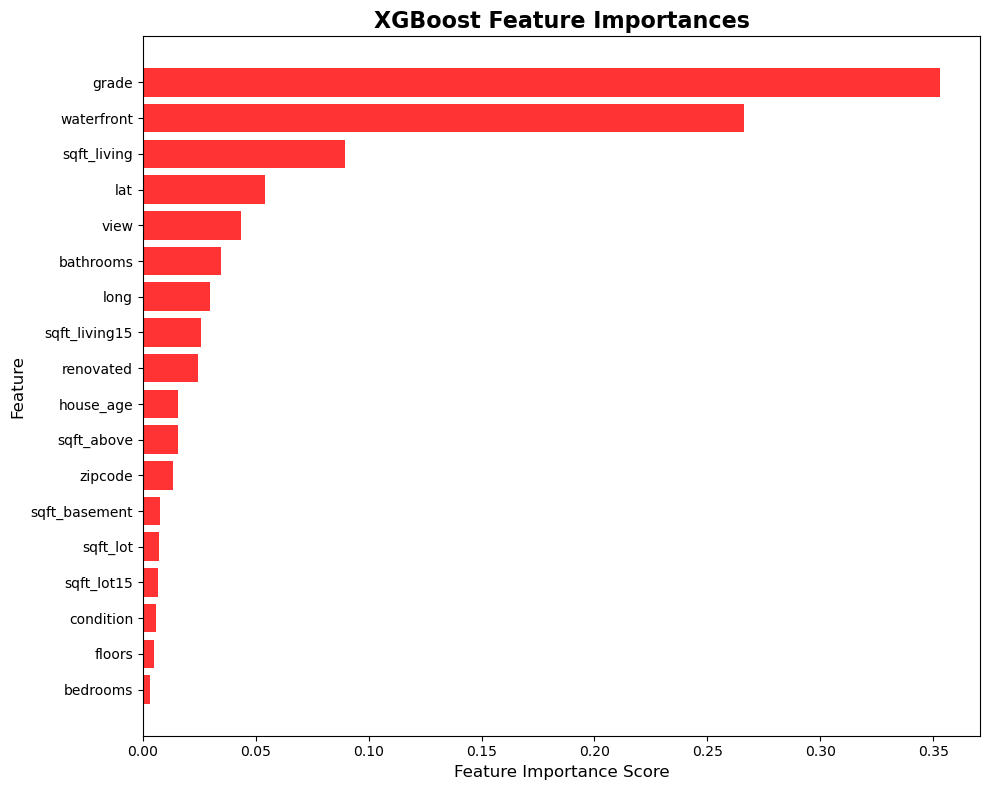

In [76]:
import matplotlib.pyplot as plt

feature_names = X_train.drop(['price', 'id'], axis=1).columns
feature_importances = XGB_model.feature_importances_
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
})

# Sort by importance:
feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=True)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df["Feature"], feat_imp_df["Importance"], color="red", alpha=0.8)
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("XGBoost Feature Importances", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

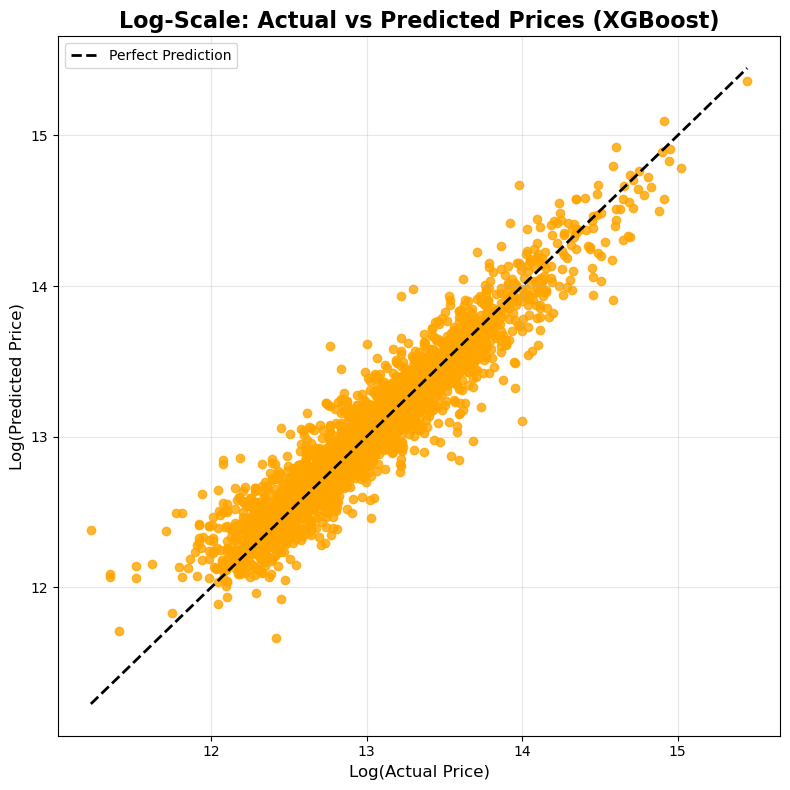

In [77]:
plt.figure(figsize=(8, 8))

plt.scatter(np.log1p(y_val), np.log1p(y_val_pred_XGB), color="orange", alpha=0.8)

# 45-degree reference line (perfect prediction)
min_val = min(np.log1p(y_val).min(), np.log1p(y_val_pred_XGB).min())
max_val = max(np.log1p(y_val).max(), np.log1p(y_val_pred_XGB).max())

plt.plot([min_val, max_val], [min_val, max_val], color="black", linestyle="--", linewidth=2, label="Perfect Prediction")

plt.xlabel("Log(Actual Price)", fontsize=12)
plt.ylabel("Log(Predicted Price)", fontsize=12)
plt.title("Log-Scale: Actual vs Predicted Prices (XGBoost)", fontsize=16, fontweight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

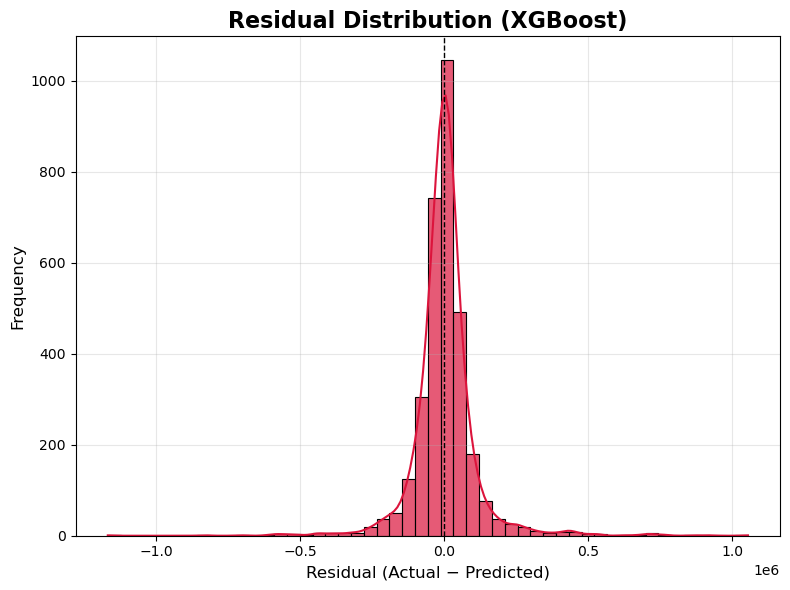

In [78]:
import seaborn as sns
# Compute residuals
residuals = y_val - y_val_pred_XGB

plt.figure(figsize=(8, 6))

sns.histplot(
    residuals,
    bins=50,
    kde=True,
    color="crimson",
    alpha=0.7
)

plt.axvline(0, color="black", linestyle="--", linewidth=1)

plt.xlabel("Residual (Actual − Predicted)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Residual Distribution (XGBoost)", fontsize=16, fontweight="bold")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

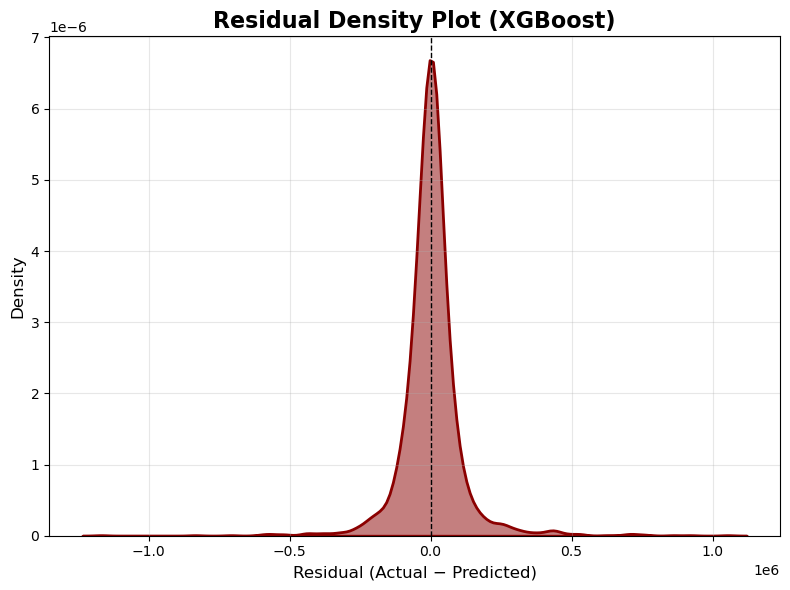

In [79]:
plt.figure(figsize=(8, 6))

sns.kdeplot(
    residuals,
    color="darkred",
    linewidth=2,
    fill=True,
    alpha=0.5
)

plt.axvline(0, color="black", linestyle="--", linewidth=1)

plt.xlabel("Residual (Actual − Predicted)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Residual Density Plot (XGBoost)", fontsize=16, fontweight="bold")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

 # ✅ Step 5: Save Model

In [80]:
import joblib

joblib.dump(XGB_model, 'XGB_model.pkl')
print("✓ XGBoost model saved successfully")

✓ XGBoost model saved successfully


# 🧠 Step 6: PyTorch Setup & Image Preprocessing

In [81]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models

torch.manual_seed(42)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

# 🏠 Step 7: Custom PyTorch Dataset & DataLoader Setup

In [82]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class HouseImageDataset(Dataset):
    """
    Custom PyTorch Dataset for loading house images and prices.
    Each sample returns:
        - image tensor (after transforms)
        - normalized price (in millions)
    """
    def __init__(self, df, image_dir, transform=None):
        # Reset index to ensure consistent row access
        self.df = df.reset_index(drop=True)
        
        # Directory containing images
        self.image_dir = image_dir
        
        # Image transformations (augmentation / normalization)
        self.transform = transform
        
        # Store valid indices
        self.valid_indices = list(range(len(self.df)))

    def __len__(self):
        # Total number of valid samples
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Map dataloader index to dataframe index
        real_idx = self.valid_indices[idx]
        row = self.df.loc[real_idx]

        # Image file name is based on the 'id' column
        img_id = str(int(row["id"]))
        img_path = os.path.join(self.image_dir, img_id + ".png")

        # Load image and ensure RGB format
        image = Image.open(img_path).convert("RGB")

        # Apply image transformations if provided
        if self.transform:
            image = self.transform(image)

        # Normalize price to millions to stabilize training
        price = torch.tensor(row["price"] / 1e6, dtype=torch.float32)

        return image, price

# Dataset Initialization:
train_dataset = HouseImageDataset(X_train, image_dir="images_train", transform=train_transform)
val_dataset = HouseImageDataset(X_val, image_dir="images_train", transform=val_transform)

# DataLoaders:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)

# 🧬 Step 8: Image-Only CNN Regression Model (ResNet-50)

In [83]:
import torch
import torch.nn as nn
import torchvision.models as models


class ImageOnlyRegressor(nn.Module):
    """
    CNN-based regression model using a ResNet-50 backbone
    to predict house prices from satellite images.
    """
    def __init__(self, dropout=0.3):
        super().__init__()

        # Load pretrained ResNet-50 backbone (ImageNet weights)
        self.backbone = models.resnet50(
            weights=models.ResNet50_Weights.IMAGENET1K_V2
        )

        # Enable fine-tuning for all backbone layers
        for param in self.backbone.parameters():
            param.requires_grad = True

        # Number of features from ResNet's final pooling layer (2048)
        num_features = self.backbone.fc.in_features

        # Replace classification head with a deep regression head
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),

            # Final regression output (single continuous value)
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # Forward pass through backbone and regression head
        return self.backbone(x).squeeze(1)

# Device Configuration via GPU
device = torch.device("cuda")
print("Using device:", device)

# Initialize model and move it to GPU
model = ImageOnlyRegressor().to(device)

# Total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())

# Number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Mean Squared Error loss for regression
criterion = nn.MSELoss()

# AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

Using device: cuda
Total parameters: 26,200,129
Trainable parameters: 26,200,129


# 🔁 Step 9: Training Loop — Single Epoch Optimization

In [84]:
from tqdm import tqdm

def train_one_epoch(model, loader):
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): CNN regression model
        loader (DataLoader): Training data loader

    Returns:
        float: Average training loss for the epoch
    """
    model.train()
    running_loss = 0.0

    for images, targets in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(loader)

# 🧪 Step 10: Validation Loop & Regression Metrics Evaluation

In [85]:
def validate(model, loader):
    """
    Evaluates the model on the validation dataset.
    Computes:
        - Validation loss (on normalized targets)
        - RMSE, MAE, R² (on original dollar scale)
        - Full prediction and ground-truth arrays
    Args:
        model (nn.Module): Trained CNN regression model
        loader (DataLoader): Validation data loader
    Returns:
        tuple:
            avg_val_loss (float)
            rmse (float)
            mae (float)
            r2 (float)
            preds (np.ndarray): Predictions in dollars
            trues (np.ndarray): Ground-truth values in dollars
    """
    model.eval()
    preds_norm, trues_norm = [], []
    val_loss = 0.0

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            preds_norm.append(outputs.cpu().numpy())
            trues_norm.append(targets.cpu().numpy())

    preds_norm = np.concatenate(preds_norm)
    trues_norm = np.concatenate(trues_norm)

    # ---- de-normalize to dollars ----
    preds = preds_norm * 1e6
    trues = trues_norm * 1e6

    rmse = root_mean_squared_error(trues, preds)
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)

    return val_loss/len(loader), rmse, mae, r2, preds, trues

# 💾 Step 11: Model Checkpointing & Training Resume Utilities

In [86]:
import os

# Checkpoint Directory & Paths:

os.makedirs("checkpoints", exist_ok=True)
CHECKPOINT_PATH = os.path.join("checkpoints", "image_only_checkpoint.pth")
BEST_MODEL_PATH = os.path.join("checkpoints", "image_only_best.pth")


# Save Checkpoint:

def save_checkpoint(epoch, model, optimizer, best_rmse):
    """
    Saves the current training state.
    Args:
        epoch (int): Current epoch number
        model (nn.Module): Model to be saved
        optimizer (Optimizer): Optimizer state
        best_rmse (float): Best validation RMSE so far
    """
    torch.save(
        {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "best_rmse": best_rmse
        },
        CHECKPOINT_PATH
    )


# Load Checkpoint:

def load_checkpoint(model, optimizer, device):
    """
    Loads training state from the latest checkpoint if available.
    Args:
        model (nn.Module): Model instance
        optimizer (Optimizer): Optimizer instance
        device (torch.device): CPU or GPU
    Returns:
        start_epoch (int): Epoch to resume from
        best_rmse (float): Best RMSE stored in checkpoint
    """
    if os.path.exists(CHECKPOINT_PATH):
        # Load checkpoint safely to the correct device
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

        # Restore model and optimizer states
        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])

        # Resume from next epoch
        start_epoch = checkpoint["epoch"] + 1
        best_rmse = checkpoint["best_rmse"]

        print(f"✓ Resuming from epoch {start_epoch}")
        return start_epoch, best_rmse
    else:
        # No checkpoint found → start training from scratch
        print("✓ No checkpoint found. Starting fresh.")
        return 0, float("inf")

# 🚀 Step 12: Full Training Loop with Validation, Checkpointing & Best-Model Tracking

In [29]:
EPOCHS = 10

# Tracking metrics across epochs
train_losses = []
val_losses = []
val_rmses = []
val_r2s = []

# Resume training if checkpoint exists
start_epoch, best_val_rmse = load_checkpoint(model, optimizer, device)


# Training Loop
for epoch in range(start_epoch, EPOCHS):
    print("\n" + "=" * 55)
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("=" * 55)

    # Train for one epoch
    train_loss = train_one_epoch(model, train_loader)
    train_losses.append(train_loss)

    # Validate after training epoch
    val_loss, val_rmse, val_mae, val_r2, val_preds, val_trues = validate(model, val_loader)

    # Store validation metrics
    val_losses.append(val_loss)
    val_rmses.append(val_rmse)
    val_r2s.append(val_r2)

    # Logging
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val RMSE:   {val_rmse:.4f}")
    print(f"Val MAE:    {val_mae:.4f}")
    print(f"Val R2:     {val_r2:.4f}")

    # Checkpointing:
    save_checkpoint(epoch, model, optimizer, best_val_rmse) # Save latest checkpoint every epoch

    # Save model only if validation RMSE improves
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print("✓ Best model updated")

✓ No checkpoint found. Starting fresh.

Epoch 1/10


Train Loss: 0.1439
Val Loss:   0.0997
Val RMSE:   315931.3750
Val MAE:    194728.5312
Val R2:     0.2046
✓ Best model updated

Epoch 2/10


Train Loss: 0.1086
Val Loss:   0.0914
Val RMSE:   302513.5312
Val MAE:    177113.5000
Val R2:     0.2707
✓ Best model updated

Epoch 3/10


Train Loss: 0.0910
Val Loss:   0.0776
Val RMSE:   278569.5938
Val MAE:    169281.8906
Val R2:     0.3816
✓ Best model updated

Epoch 4/10


Train Loss: 0.0915
Val Loss:   0.0948
Val RMSE:   307963.0938
Val MAE:    187033.3125
Val R2:     0.2442

Epoch 5/10


Train Loss: 0.0826
Val Loss:   0.2941
Val RMSE:   542546.9375
Val MAE:    259155.2812
Val R2:     -1.3457

Epoch 6/10


Train Loss: 0.0797
Val Loss:   0.0873
Val RMSE:   295629.3125
Val MAE:    198179.8438
Val R2:     0.3035

Epoch 7/10


Train Loss: 0.0763
Val Loss:   0.0720
Val RMSE:   268471.9062
Val MAE:    167510.5469
Val R2:     0.4256
✓ Best model updated

Epoch 8/10


Train Loss: 0.0716
Val Loss:   0.0687
Val RMSE:   262086.3125
Val MAE:    167003.5938
Val R2:     0.4526
✓ Best model updated

Epoch 9/10


Train Loss: 0.0703
Val Loss:   0.0853
Val RMSE:   291999.6562
Val MAE:    184251.3438
Val R2:     0.3205

Epoch 10/10


Train Loss: 0.0641
Val Loss:   0.1806
Val RMSE:   424514.2812
Val MAE:    214411.8906
Val R2:     -0.4361


In [87]:
import warnings 
warnings.filterwarnings('ignore')

In [88]:
BEST_MODEL_PATH = os.path.join("checkpoints", "image_only_best.pth")

state_dict = torch.load(BEST_MODEL_PATH,map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("✓ Loaded Successfully!!!")

✓ Loaded Successfully!!!


# 📊 Step 13: Training Visualization — Loss, RMSE & R² Curves

### 1️⃣ Training vs Validation Loss:

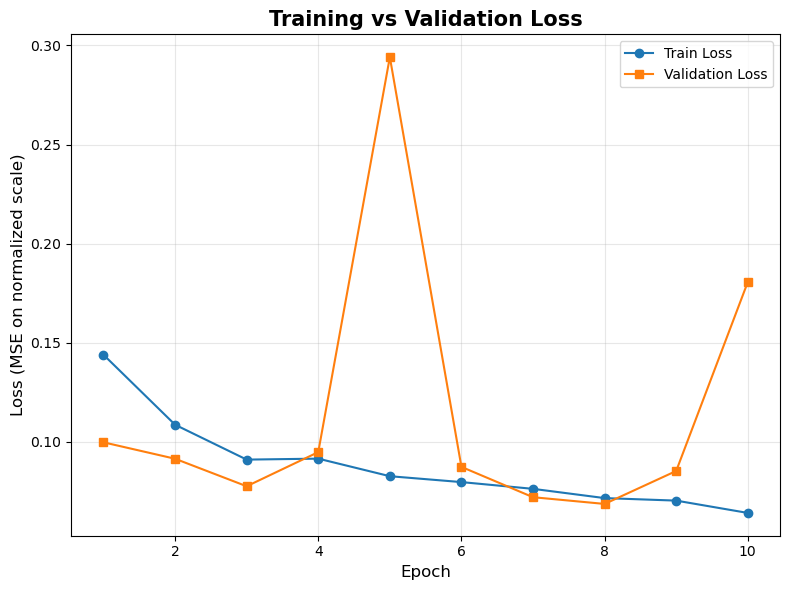

In [33]:
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(8, 6))

plt.plot(epochs_range, train_losses, marker="o", label="Train Loss")
plt.plot(epochs_range, val_losses, marker="s", label="Validation Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE on normalized scale)", fontsize=12)
plt.title("Training vs Validation Loss", fontsize=15, fontweight="bold")

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 2️⃣ Validation R² Curve:

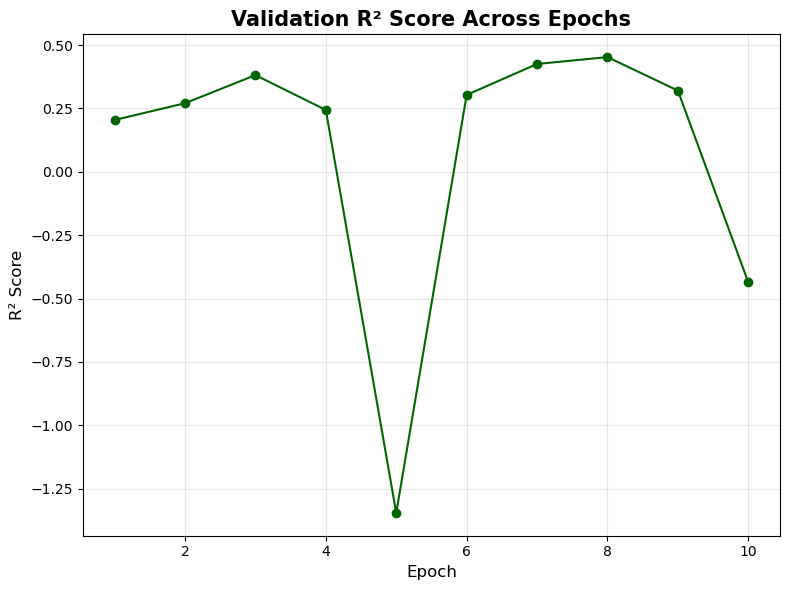

In [36]:
plt.figure(figsize=(8, 6))

plt.plot(epochs_range, val_r2s, marker="o", color="darkgreen")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.title("Validation R² Score Across Epochs", fontsize=15, fontweight="bold")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 📉 Step 14: Residual Distribution Analysis — Histogram & KDE

### 1️⃣ Residual Histogram + KDE

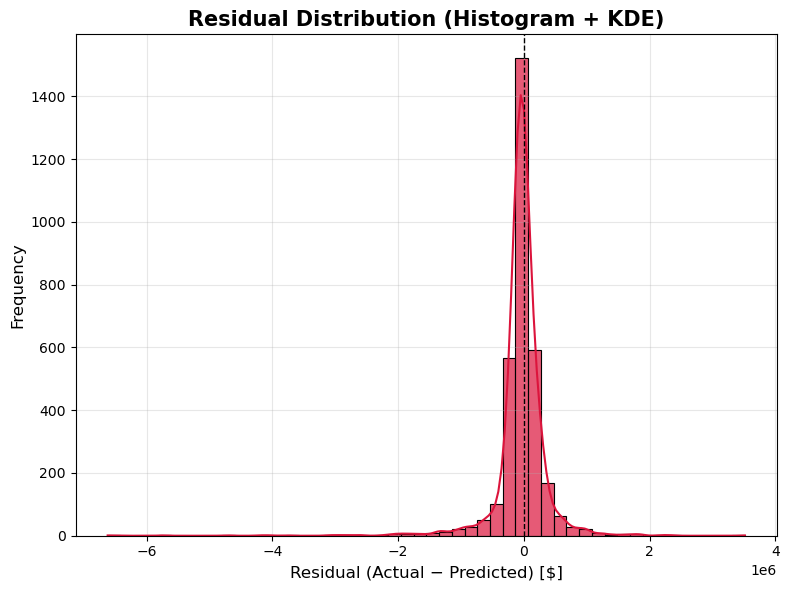

In [38]:
residuals = val_trues - val_preds # Residuals (Final Epoch) = Actual price − Predicted price (in dollars)
plt.figure(figsize=(8, 6))

sns.histplot(residuals, bins=50, kde=True, color="crimson", alpha=0.7)

# Zero-error reference line
plt.axvline(0, color="black", linestyle="--", linewidth=1)

plt.xlabel("Residual (Actual − Predicted) [$]", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Residual Distribution (Histogram + KDE)", fontsize=15, fontweight="bold")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 2️⃣ Residual Density Only

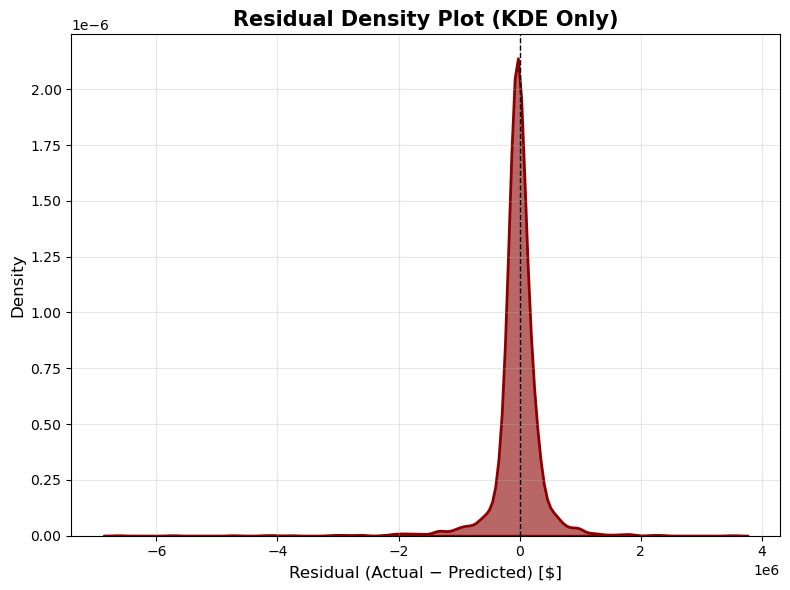

In [39]:
plt.figure(figsize=(8, 6))

sns.kdeplot(
    residuals,
    fill=True,
    color="darkred",
    linewidth=2,
    alpha=0.6
)

# Zero-error reference line
plt.axvline(0, color="black", linestyle="--", linewidth=1)

plt.xlabel("Residual (Actual − Predicted) [$]", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Residual Density Plot (KDE Only)", fontsize=15, fontweight="bold")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 🔍 Step 15: Feature-Enhanced CNN Wrapper for Grad-CAM Visualization

In [41]:
import torch.nn.functional as F
import torchvision.transforms as T

class ImageRegressorWithFeatures(nn.Module):
    """
    Wrapper model that exposes intermediate convolutional feature maps
    required for Grad-CAM visualization, while preserving regression output.
    """
    def __init__(self, trained_model):
        super().__init__()
        self.features = nn.Sequential(*list(trained_model.backbone.children())[:-2])
        self.pool = trained_model.backbone.avgpool
        self.fc = trained_model.backbone.fc

    def forward(self, x):
        feat = self.features(x)
        pooled = self.pool(feat).view(x.size(0), -1)
        out = self.fc(pooled)
        return out, feat

cam_model = ImageRegressorWithFeatures(model).to(device)
cam_model.eval()

ImageRegressorWithFeatures(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

# 🔥 Step 16: Grad-CAM Implementation & Visual Explanation Overlay

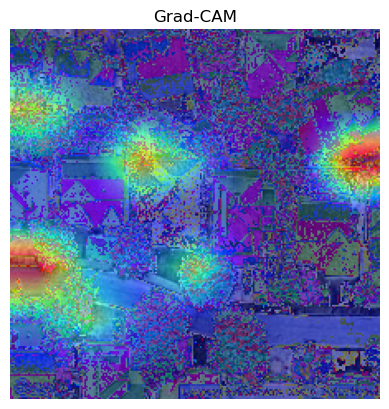

In [42]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output
            self.activations.requires_grad_(True)

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor):
        input_tensor.requires_grad_(True)
        self.model.zero_grad()
        output, _ = self.model(input_tensor)
        output.backward(torch.ones_like(output))

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)

        cam -= cam.min()
        cam /= (cam.max() + 1e-8)
        return cam

target_layer = cam_model.features[-1]
gradcam = GradCAM(cam_model, target_layer)

sample_img, _ = val_dataset[0]
input_tensor = sample_img.unsqueeze(0).to(device)

cam = gradcam.generate(input_tensor)
cam = cam.squeeze().detach().cpu().numpy()
cam_resized = F.interpolate(
    torch.tensor(cam).unsqueeze(0).unsqueeze(0),
    size=(224, 224),
    mode='bilinear',
    align_corners=False
).squeeze().numpy()

plt.imshow(T.ToPILImage()(sample_img))
plt.imshow(cam_resized, cmap='jet', alpha=0.5)
plt.title("Grad-CAM")
plt.axis("off")
plt.show()

🔴 Hot regions → areas that most influenced the price prediction

🟡 Moderate regions → partial influence

🔵 Cold regions → ignored by the model

# 🧪 Step 17: Grad-CAM Comparison — High-Error vs Low-Error Predictions

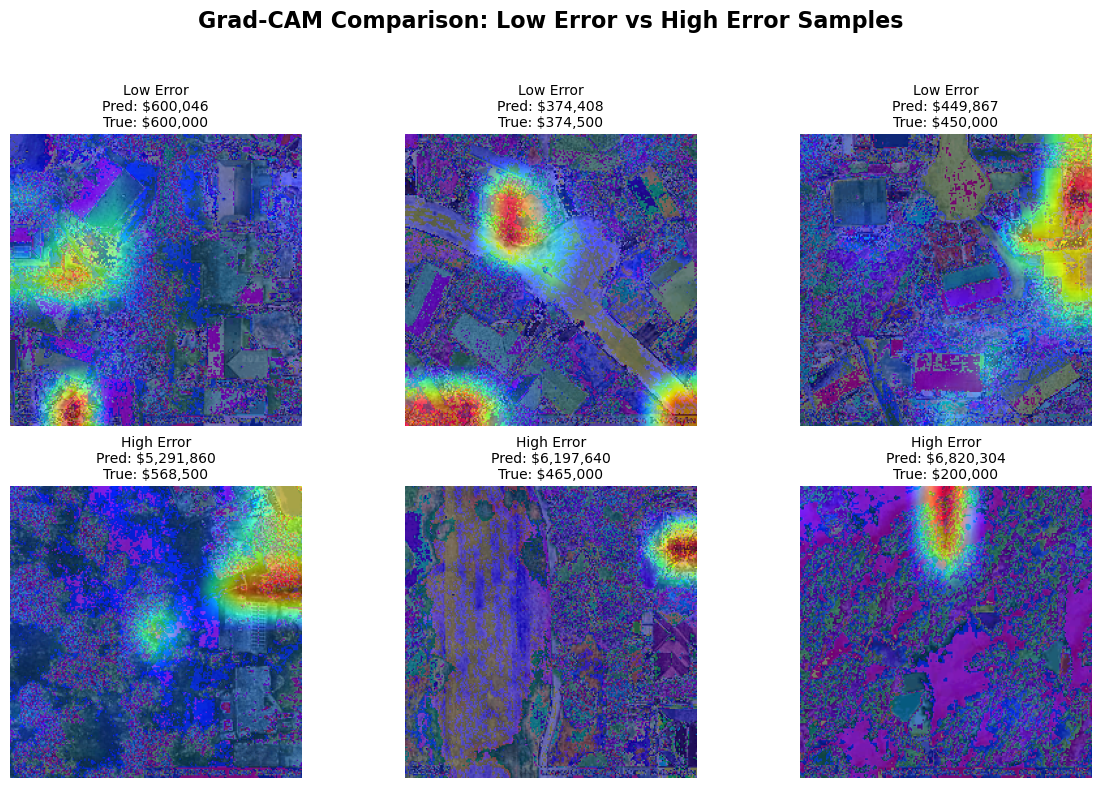

In [44]:
def visualize_gradcam_comparison(cam_model, gradcam, dataset, preds, trues, device, k=3):
    """
    Visualizes Grad-CAM heatmaps for the highest-error and lowest-error samples.

    Args:
        cam_model (nn.Module): Feature-enabled model for Grad-CAM
        gradcam (GradCAM): Initialized Grad-CAM object
        dataset (Dataset): Validation dataset
        preds (np.ndarray): Model predictions (dollars)
        trues (np.ndarray): Ground-truth values (dollars)
        device (torch.device): CPU or GPU
        k (int): Number of samples to visualize per category
    """
    
    errors = np.abs(trues - preds)
    # Indices for lowest and highest error sample
    low_error_idxs = np.argsort(errors)[:k]
    high_error_idxs = np.argsort(errors)[-k:]

    selected = [("Low Error", i) for i in low_error_idxs] + \
               [("High Error", i) for i in high_error_idxs]

    
    plt.figure(figsize=(4 * k, 8))
    for idx, (label, data_idx) in enumerate(selected, start=1):
        # Load image from dataset
        img, _ = dataset[data_idx]
        input_tensor = img.unsqueeze(0).to(device)

        # Generate Grad-CAM
        cam = gradcam.generate(input_tensor)
        cam = cam.squeeze().detach().cpu().numpy()

        # Resize CAM to image resolution
        cam_resized = F.interpolate(
            torch.tensor(cam).unsqueeze(0).unsqueeze(0),
            size=(224, 224),
            mode="bilinear",
            align_corners=False
        ).squeeze().numpy()

        # Plot original image + heatmap overlay:
        plt.subplot(2, k, idx)
        plt.imshow(T.ToPILImage()(img))
        plt.imshow(cam_resized, cmap="jet", alpha=0.5)
        plt.axis("off")
        plt.title(
            f"{label}\n"
            f"Pred: ${preds[data_idx]:,.0f}\n"
            f"True: ${trues[data_idx]:,.0f}",
            fontsize=10
        )

    plt.suptitle(
        "Grad-CAM Comparison: Low Error vs High Error Samples",
        fontsize=16,
        fontweight="bold"
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
visualize_gradcam_comparison(cam_model=cam_model, gradcam=gradcam, dataset=val_dataset, preds=val_preds, trues=val_trues, device=device, k=3)

Low-error samples:   
🔹 Heatmaps are focused on meaningful spatial context (roads, water, density, greenery)

High-error samples:   
🔹 Diffuse or misleading attention → missing context, occlusion, or rare patterns   
🔹 Often indicates where tabular features or multimodal fusion would help

# 🧭 Step 18: Guided Grad-CAM — High-Resolution Visual Explanations

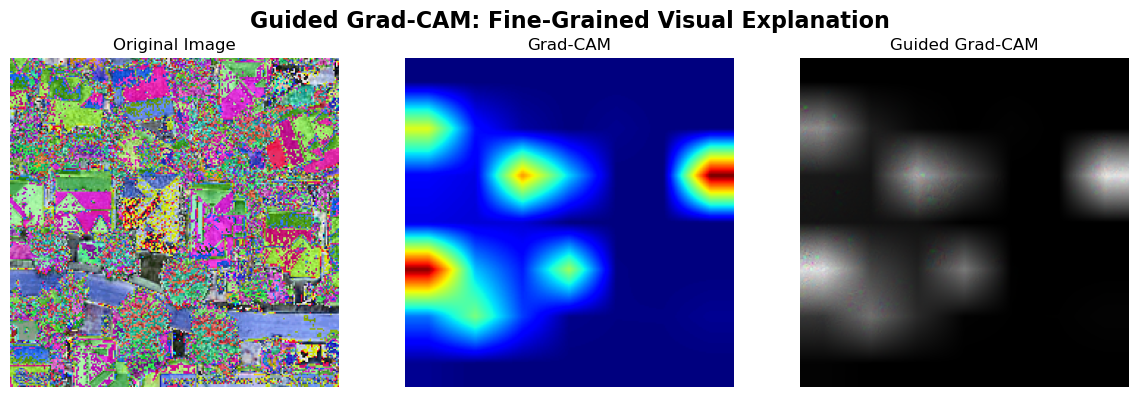

In [46]:
# Guided Backpropagation Module:
class GuidedBackpropReLU(nn.Module):
    """
    Custom ReLU for Guided Backpropagation.
    Allows only positive gradients to flow backward.
    """
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = input * positive_mask
        self.save_for_backward = positive_mask
        return output

    def backward(self, grad_output):
        grad_input = grad_output.clone()
        grad_input[self.save_for_backward == 0] = 0
        grad_input[grad_output < 0] = 0
        return grad_input

# Replace ReLU with Guided ReLU:
def replace_relu_with_guided(module):
    """
    Recursively replaces all ReLU layers with GuidedBackpropReLU.
    """
    for name, child in module.named_children():
        if isinstance(child, nn.ReLU):
            setattr(module, name, GuidedBackpropReLU())
        else:
            replace_relu_with_guided(child)

# Guided Backpropagation Wrapper:
class GuidedBackprop:
    # Computes guided backpropagation gradients w.r.t. input image.
    def __init__(self, model):
        self.model = model
        self.model.eval()
        replace_relu_with_guided(self.model)

    def generate(self, input_tensor):
        """
        Generates guided backprop gradients.
        Args:
            input_tensor (Tensor): Input image (1, C, H, W)
        Returns:
            np.ndarray: Guided backprop gradient map
        """
        input_tensor.requires_grad_(True)

        # Forward pass
        output, _ = self.model(input_tensor)

        # Backward pass (regression → use ones)
        self.model.zero_grad()
        output.backward(torch.ones_like(output))

        # Get gradients w.r.t input
        guided_grads = input_tensor.grad.detach().cpu().numpy()[0]

        # Normalize for visualization
        guided_grads -= guided_grads.min()
        guided_grads /= (guided_grads.max() + 1e-8)

        return guided_grads

# Guided Grad-CAM = Grad-CAM × Guided Backprop:
def guided_gradcam(cam, guided_grads):
    """
    Combines Grad-CAM heatmap with Guided Backprop gradients.
    Args:
        cam (np.ndarray): Grad-CAM heatmap (H, W)
        guided_grads (np.ndarray): Guided backprop gradients (C, H, W)
    Returns:
        np.ndarray: Guided Grad-CAM visualization
    """
    cam = np.expand_dims(cam, axis=0)  # (1, H, W)
    guided_cam = guided_grads * cam

    # Normalize
    guided_cam -= guided_cam.min()
    guided_cam /= (guided_cam.max() + 1e-8)

    return guided_cam

# Generate Guided Grad-CAM Visualization:
guided_bp = GuidedBackprop(cam_model)
sample_img, _ = val_dataset[0]
input_tensor = sample_img.unsqueeze(0).to(device)

# Grad-CAM heatmap:
cam = gradcam.generate(input_tensor)
cam = cam.squeeze().detach().cpu().numpy()
cam_resized = F.interpolate(
    torch.tensor(cam).unsqueeze(0).unsqueeze(0),
    size=(224, 224),
    mode="bilinear",
    align_corners=False
).squeeze().numpy()
guided_grads = guided_bp.generate(input_tensor)
guided_gc = guided_gradcam(cam_resized, guided_grads)


plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(T.ToPILImage()(sample_img))
plt.title("Original Image")
plt.axis("off")

# Grad-CAM
plt.subplot(1, 3, 2)
plt.imshow(cam_resized, cmap="jet")
plt.title("Grad-CAM")
plt.axis("off")

# Guided Grad-CAM
plt.subplot(1, 3, 3)
plt.imshow(np.transpose(guided_gc, (1, 2, 0)))
plt.title("Guided Grad-CAM")
plt.axis("off")

plt.suptitle("Guided Grad-CAM: Fine-Grained Visual Explanation", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

# 🔗 Step 19: Model Fusion Using CNN and XGBoost Predictions

In [89]:
from sklearn.linear_model import LinearRegression
cnn_preds = []

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        preds = model(images).cpu().numpy()
        cnn_preds.extend(preds)

y_pred_cnn = np.array(cnn_preds).reshape(-1)

X_fusion = np.column_stack([y_val_pred_XGB, y_pred_cnn])

fusion_model = LinearRegression()
fusion_model.fit(X_fusion, y_val)
y_pred_fusion = fusion_model.predict(X_fusion)

RMSE_fusion = root_mean_squared_error(y_val, y_pred_fusion)
R2_fusion = r2_score(y_val, y_pred_fusion)
MAE_fusion = mean_absolute_error(y_val, y_pred_fusion)
print(f"Fusion Model → RMSE: {RMSE_fusion:,.0f}, R²: {R2_fusion:.4f}, MAE: {MAE_fusion:.4f}")

Fusion Model → RMSE: 112,067, R²: 0.8999, MAE: 64782.4570


In [53]:
joblib.dump(fusion_model, 'fusion_model.pkl')

['fusion_model.pkl']

# 📊 Step 20: Performance Comparison — XGBoost vs CNN–XGBoost Fusion

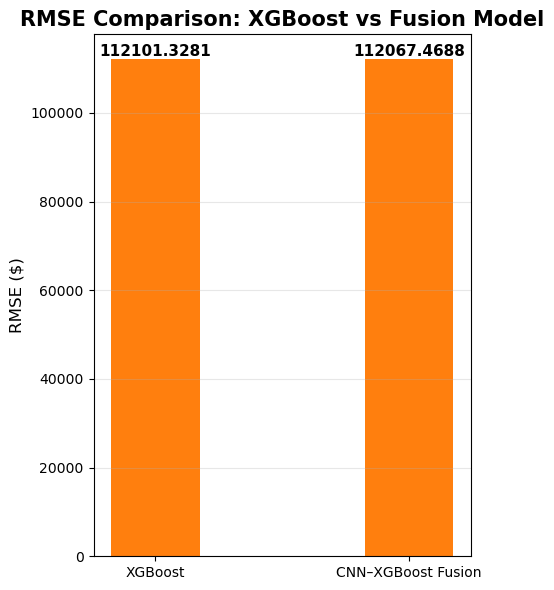

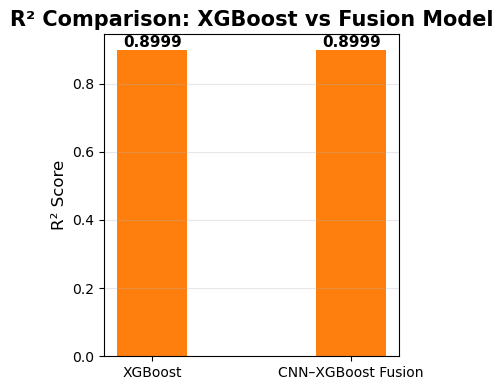

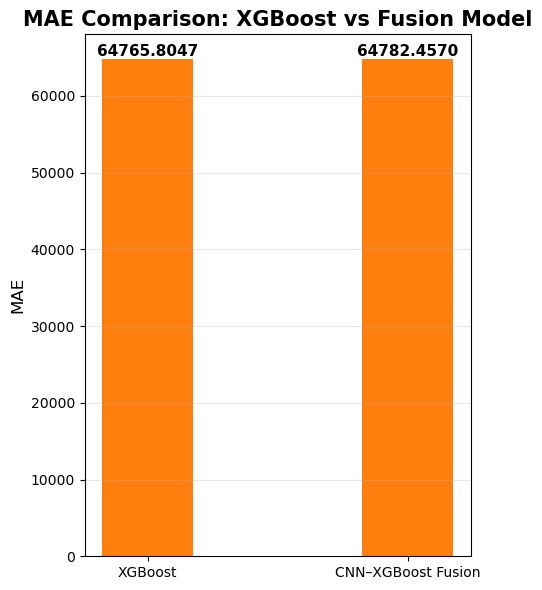

In [70]:
model_names = ["XGBoost", "CNN–XGBoost Fusion"]

RMSE_values = [RMSE_XGB, RMSE_fusion]
R2_values = [R2_XGB, R2_fusion]
MAE_values = [MAE_XGB, MAE_fusion]
x = np.arange(len(model_names))

def add_bar_labels(bars, fmt="{:.4f}"):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            fmt.format(height),
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold"
        )


# RMSE Comparison:
plt.figure(figsize=(5, 6))

bars = plt.bar(x, RMSE_values, width=0.35)
add_bar_labels(bars, fmt="{:.4f}")

plt.bar(x, RMSE_values, width=0.35)
plt.xticks(x, model_names)
plt.ylabel("RMSE ($)", fontsize=12)
plt.title("RMSE Comparison: XGBoost vs Fusion Model", fontsize=15, fontweight="bold")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# R² Comparison:
plt.figure(figsize=(4, 4))

bars = plt.bar(x, R2_values, width=0.35)
add_bar_labels(bars, fmt="{:.4f}")

plt.bar(x, R2_values, width=0.35)
plt.xticks(x, model_names)
plt.ylabel("R² Score", fontsize=12)
plt.title("R² Comparison: XGBoost vs Fusion Model", fontsize=15, fontweight="bold")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# MAE Comparison:
plt.figure(figsize=(5, 6))

bars = plt.bar(x, MAE_values, width=0.35)
add_bar_labels(bars, fmt="{:.4f}")

plt.bar(x, MAE_values, width=0.35)
plt.xticks(x, model_names)
plt.ylabel("MAE", fontsize=12)
plt.title("MAE Comparison: XGBoost vs Fusion Model", fontsize=15, fontweight="bold")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 📤 Step 21: Final Price Prediction on Test Dataset using CNN–XGBoost Fusion (CSV Export)

In [90]:
X_test = df_test

model = ImageOnlyRegressor().to(device)
model.load_state_dict(torch.load("checkpoints/image_only_best.pth",map_location=device))
model.eval()
print("✓ Loaded Successfully!!!")

✓ Loaded Successfully!!!


In [91]:
class HouseImageTestDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.valid_indices = list(range(len(self.df)))

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        real_idx = self.valid_indices[idx]
        row = self.df.loc[real_idx]
        img_id = str(int(row["id"]))
        img_path = os.path.join(self.image_dir, img_id + ".png")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
            
        return image, row['id']

# Dataset and DataLoaders Initialization:
test_dataset = HouseImageTestDataset(df_test, image_dir="images_test", transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True)

In [92]:
XGB_test_pred = XGB_model.predict(X_test.drop(['id'], axis=1))

In [93]:
CNN_test_pred = []
with torch.no_grad():
    for images, _ in test_loader:  
        images = images.to(device)
        preds = model(images).cpu().numpy()
        CNN_test_pred.extend(preds)
CNN_test_pred = np.array(CNN_test_pred)
CNN_test_pred.shape

(5404,)

In [94]:
XGB_test_pred.shape

(5404,)

In [95]:
X_test_fusion = np.column_stack([XGB_test_pred, CNN_test_pred])
test_pred_fusion = fusion_model.predict(X_test_fusion)

In [96]:
preds_final = pd.DataFrame({
    "id": df_test["id"],
    "predicted_price": test_pred_fusion
})
preds_final.to_csv("23323022_final.csv", index=False)
print("✓ Test predictions saved to 23323022_final.csv")

✓ Test predictions saved to 23323022_final.csv
